In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:72,5% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import dill
import itertools

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from mlxtend.plotting import plot_confusion_matrix
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objs as gobj

from sklearn import ensemble
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score, confusion_matrix, recall_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split, KFold, learning_curve

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

init_notebook_mode(connected=True)
from plotly.tools import FigureFactory as ff

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Пути к директориям и файлам

In [5]:
TRAIN_DATASET_PATH = '.././data/heart_failure_clinical_records_dataset.csv'

### Загрузка данных

In [6]:
df = pd.read_csv(TRAIN_DATASET_PATH)

| Feature  | Explanation | Measurement | Range |
| :------------- | :------------- | :------------- | :------------- |
| `age`   | Age of the patient | Years | (40, ..., 95) |
| `anaemia`  | Decrease of red blood cells or hemoglobin<br> (haematocrit levels were lower than 36%)  | Boolean  |  0, 1 |
| `creatinine_phosphokinase` | Level of the CPK enzyme in the blood | mcg/L | (23, ..., 7861) |
| `diabetes` | If the patient has diabetes | Boolean | 0, 1 |
| `ejection_fraction` | Percentage of blood leaving the heart<br> at each contraction | Percentage | (14, ..., 80) |
| `high_blood_pressure`  | If a patient has hypertension | Boolean | 0, 1 |
| `platelets` | Platelets in the blood | kiloplatelets/mL | (25.01, ..., 850.00) |
| `serum_creatinine` | Level of creatinine in the blood | mg/dL | (0.50, ..., 9.40) |
| `serum_sodium` | Level of sodium in the blood |  mEq/L | 114, ..., 148 |
| `sex` | Woman or man | Binary | 0, 1 |
| `smoking` | If the patient smokes | Boolean | 0, 1 |
| `time` | Follow-up period | Days | (4, ..., 285) |
| `DEATH_EVENT` | If the patient died during the follow-up period |  Boolean | 0, 1 |

### Изучение датасета

In [7]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.00000,0,582,0,20,1,265000.00000,1.90000,130,1,0,4,1
1,55.00000,0,7861,0,38,0,263358.03000,1.10000,136,1,0,6,1
2,65.00000,0,146,0,20,0,162000.00000,1.30000,129,1,1,7,1
3,50.00000,1,111,0,20,0,210000.00000,1.90000,137,1,0,7,1
4,65.00000,1,160,1,20,0,327000.00000,2.70000,116,0,0,8,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


### EDA

In [9]:
df['anaemia'] = df['anaemia'].apply(str)
df['diabetes'] = df['diabetes'].apply(str)
df['high_blood_pressure'] = df['high_blood_pressure'].apply(str)
df['smoking'] = df['smoking'].apply(str)
df['sex'] = df['sex'].apply(str)

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.00000,60.83389,11.89481,40.00000,51.00000,60.00000,70.00000,95.00000
creatinine_phosphokinase,299.00000,581.83946,970.28788,23.00000,116.50000,250.00000,582.00000,7861.00000
ejection_fraction,299.00000,38.08361,11.83484,14.00000,30.00000,38.00000,45.00000,80.00000
platelets,299.00000,263358.02926,97804.23687,25100.00000,212500.00000,262000.00000,303500.00000,850000.00000
serum_creatinine,299.00000,1.39388,1.03451,0.50000,0.90000,1.10000,1.40000,9.40000
serum_sodium,299.00000,136.62542,4.41248,113.00000,134.00000,137.00000,140.00000,148.00000
time,299.00000,130.26087,77.61421,4.00000,73.00000,115.00000,203.00000,285.00000
DEATH_EVENT,299.00000,0.32107,0.46767,0.00000,0.00000,0.00000,1.00000,1.00000


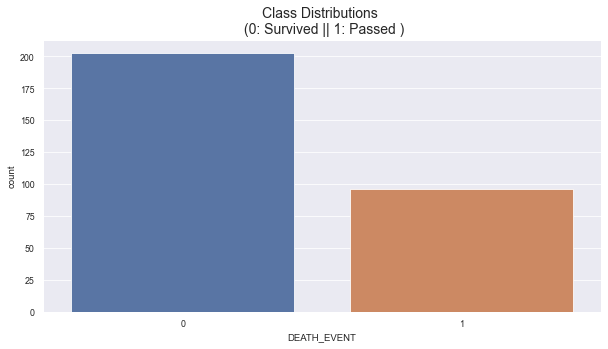

In [11]:
sns.set_theme(context = 'paper')

plt.figure(figsize = (10,5))
sns.countplot(df['DEATH_EVENT'])
plt.title('Class Distributions \n (0: Survived || 1: Passed )', fontsize=14)
plt.show()

<Figure size 1440x1080 with 0 Axes>

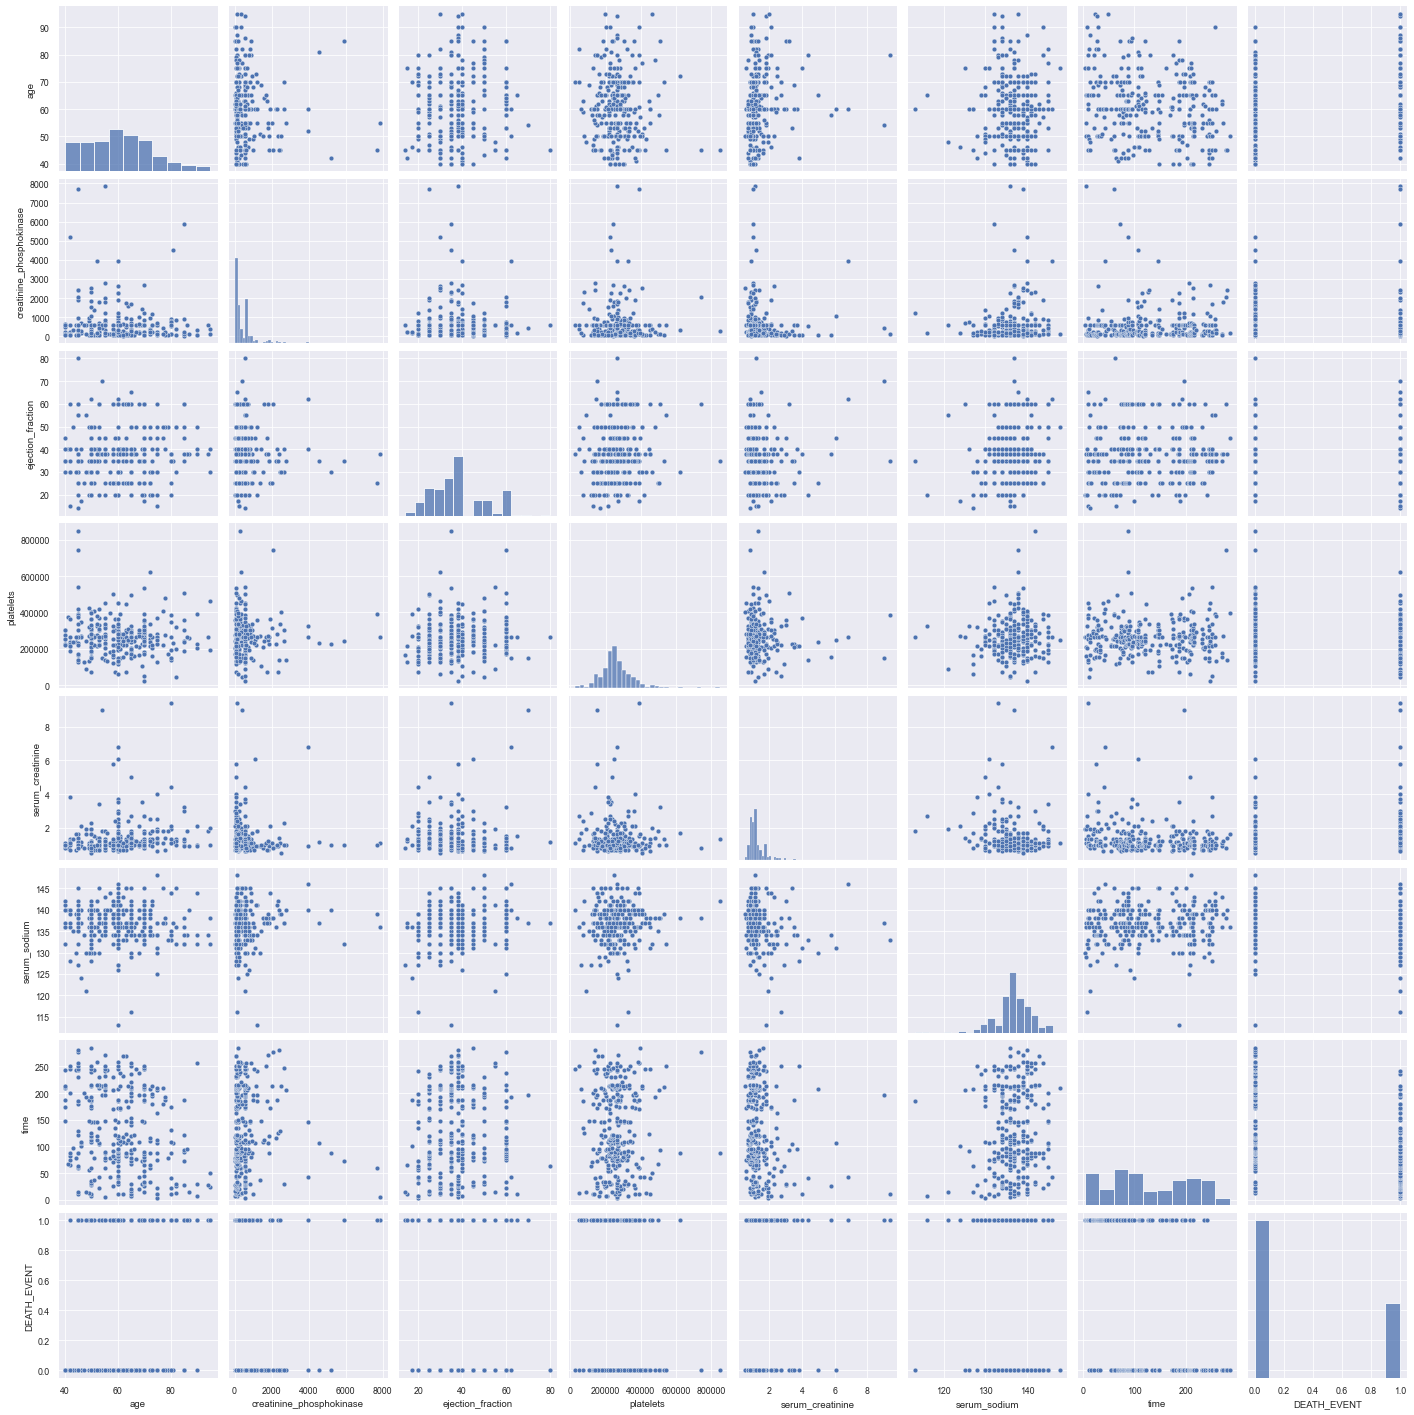

In [12]:
plt.figure(figsize = (20,15))
sns.pairplot(df)
plt.show()

### Обработка выбросов

In [13]:
def outliers_removal(feature,feature_name,dataset):
    
    q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
    print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
    feat_iqr = q75 - q25
    print('iqr: {}'.format(feat_iqr))
    
    feat_cut_off = feat_iqr * 1.5
    feat_lower, feat_upper = q25 - feat_cut_off, q75 + feat_cut_off
    print('Cut Off: {}'.format(feat_cut_off))
    print(feature_name +' Lower: {}'.format(feat_lower))
    print(feature_name +' Upper: {}'.format(feat_upper))
    
    outliers = [x for x in feature if x < feat_lower or x > feat_upper]
    print(feature_name + ' outliers for close to bankruptcy cases: {}'.format(len(outliers)))
    
    dataset = dataset.drop(dataset[(dataset[feature_name] > feat_upper) | (dataset[feature_name] < feat_lower)].index)
    print('-' * 65)
    
    return dataset

df = outliers_removal(df['age'],'age', df)
df = outliers_removal(df['creatinine_phosphokinase'],'creatinine_phosphokinase', df)
df = outliers_removal(df['ejection_fraction'],'ejection_fraction', df)
df = outliers_removal(df['platelets'],'platelets', df)
df = outliers_removal(df['serum_creatinine'],'serum_creatinine', df)
df = outliers_removal(df['serum_sodium'],'serum_sodium', df)
df = outliers_removal(df['time'],'time', df)

Quartile 25: 51.0 | Quartile 75: 70.0
iqr: 19.0
Cut Off: 28.5
age Lower: 22.5
age Upper: 98.5
age outliers for close to bankruptcy cases: 0
-----------------------------------------------------------------
Quartile 25: 116.5 | Quartile 75: 582.0
iqr: 465.5
Cut Off: 698.25
creatinine_phosphokinase Lower: -581.75
creatinine_phosphokinase Upper: 1280.25
creatinine_phosphokinase outliers for close to bankruptcy cases: 29
-----------------------------------------------------------------
Quartile 25: 30.0 | Quartile 75: 45.0
iqr: 15.0
Cut Off: 22.5
ejection_fraction Lower: 7.5
ejection_fraction Upper: 67.5
ejection_fraction outliers for close to bankruptcy cases: 2
-----------------------------------------------------------------
Quartile 25: 211500.0 | Quartile 75: 303250.0
iqr: 91750.0
Cut Off: 137625.0
platelets Lower: 73875.0
platelets Upper: 440875.0
platelets outliers for close to bankruptcy cases: 18
-----------------------------------------------------------------
Quartile 25: 0.9 | 

In [14]:
numerical_features = ["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium"]
categorical_features = ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"]

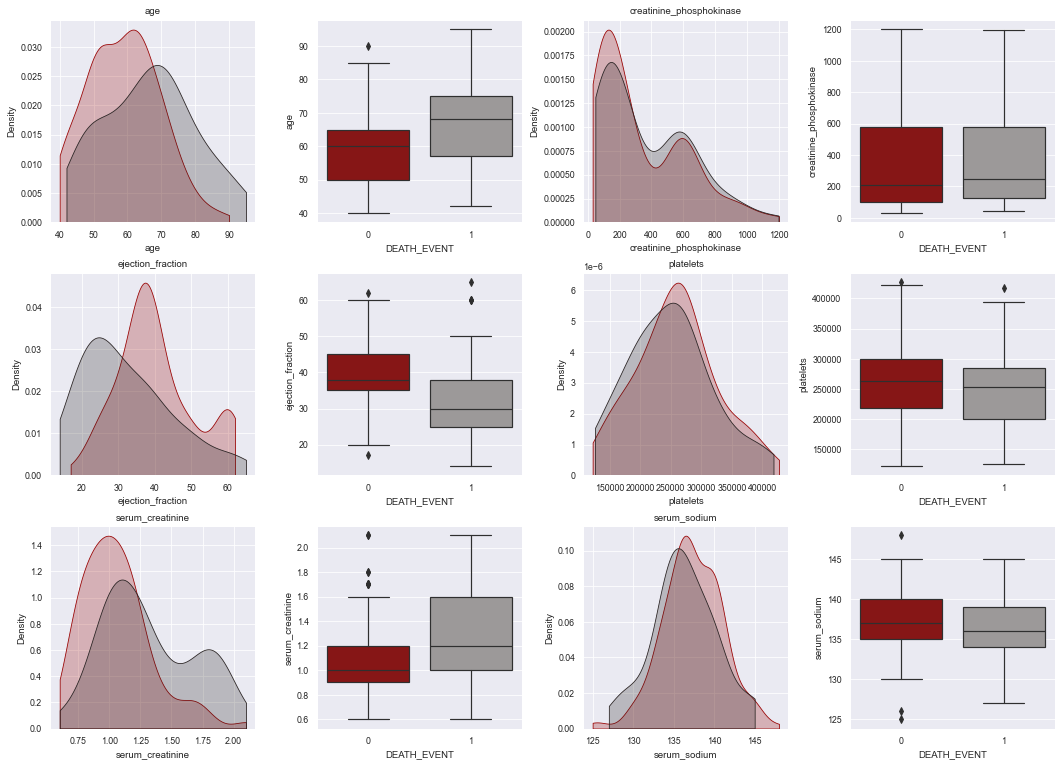

In [15]:
plt.figure(figsize=(18, 27))

for i, col in enumerate(numerical_features):
    plt.subplot(6, 4, i*2+1)
    plt.subplots_adjust(hspace =.25, wspace=.3)
    
    plt.grid(True)
    plt.title(col)
    sns.kdeplot(df.loc[df["DEATH_EVENT"]==0, col], label="alive", color = "#990303", shade=True, kernel='gau', cut=0)
    sns.kdeplot(df.loc[df["DEATH_EVENT"]==1, col], label="dead",  color = "#292323", shade=True, kernel='gau', cut=0)
    plt.subplot(6, 4, i*2+2) 
    sns.boxplot(y = col, data = df, x="DEATH_EVENT", palette = ["#990303", "#9C9999"])

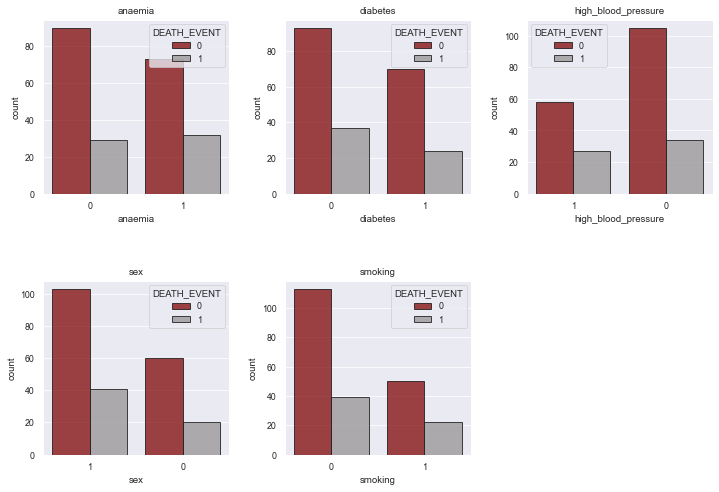

In [16]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(categorical_features):
    plt.subplot(2, 3, i+1)
    plt.title(col)
    plt.subplots_adjust(hspace =.5, wspace=.3)
    sns.countplot(data=df, x=col, hue="DEATH_EVENT", palette = ["#990303", "#9C9999"], alpha=0.8, edgecolor="k", linewidth=1)

In [17]:
X = df.drop('DEATH_EVENT', axis = 1)
y = df['DEATH_EVENT']
X.head(2)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.00000,0,582,0,20,1,265000.00000,1.90000,130,1,0,4
2,65.00000,0,146,0,20,0,162000.00000,1.30000,129,1,1,7


In [18]:
X = pd.get_dummies(X)

In [19]:
X.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,anaemia_0,anaemia_1,diabetes_0,diabetes_1,high_blood_pressure_0,high_blood_pressure_1,sex_0,sex_1,smoking_0,smoking_1
0,75.00000,582,20,265000.00000,1.90000,130,4,1,0,1,0,0,1,0,1,1,0
2,65.00000,146,20,162000.00000,1.30000,129,7,1,0,1,0,1,0,0,1,0,1
3,50.00000,111,20,210000.00000,1.90000,137,7,0,1,1,0,1,0,0,1,1,0
5,90.00000,47,40,204000.00000,2.10000,132,8,0,1,1,0,0,1,0,1,0,1
6,75.00000,246,15,127000.00000,1.20000,137,10,0,1,1,0,1,0,0,1,1,0


### Стандартизация

In [20]:
X.columns

Index(['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets',
       'serum_creatinine', 'serum_sodium', 'time', 'anaemia_0', 'anaemia_1',
       'diabetes_0', 'diabetes_1', 'high_blood_pressure_0',
       'high_blood_pressure_1', 'sex_0', 'sex_1', 'smoking_0', 'smoking_1'],
      dtype='object')

In [21]:
col = ['age','creatinine_phosphokinase','ejection_fraction',
       'platelets','serum_creatinine','serum_sodium', 'time',
       'anaemia_0', 'anaemia_1', 'diabetes_0', 'diabetes_1', 
       'high_blood_pressure_0', 'high_blood_pressure_1', 'sex_0', 'sex_1',
       'smoking_0', 'smoking_1']

In [22]:
col_trans = ColumnTransformer(remainder='passthrough',
                              transformers = [('scaler', StandardScaler(with_mean=True, with_std=True),[0,1,2,3,4,5,6])])
trans = col_trans.fit_transform(X)
X = pd.DataFrame(trans,columns = col)
X.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,anaemia_0,anaemia_1,diabetes_0,diabetes_1,high_blood_pressure_0,high_blood_pressure_1,sex_0,sex_1,smoking_0,smoking_1
0,1.19054,0.87867,-1.55577,0.13633,2.35866,-1.85472,-1.68373,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,1.00000,0.00000
1,0.35157,-0.68463,-1.55577,-1.40090,0.52415,-2.11800,-1.64447,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000
2,-0.90689,-0.81013,-1.55577,-0.68452,2.35866,-0.01175,-1.64447,0.00000,1.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000
3,2.44899,-1.03960,0.15588,-0.77406,2.97017,-1.32815,-1.63138,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000
4,1.19054,-0.32608,-1.98368,-1.92326,0.21839,-0.01175,-1.60521,0.00000,1.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000


In [23]:
#X.drop("time", axis=1, inplace=True)

In [24]:
all_features = X.columns

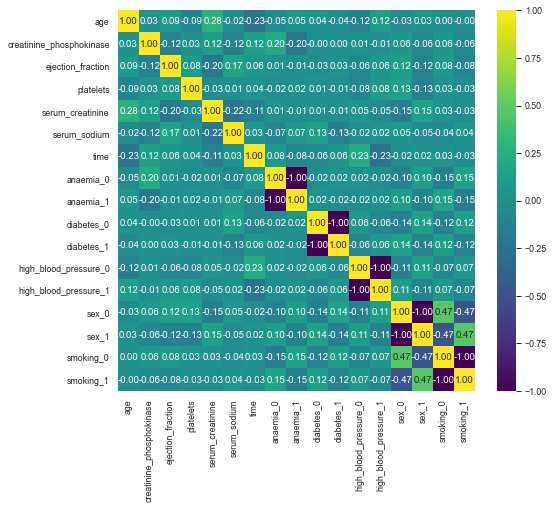

In [25]:
plt.figure(figsize=(8, 7))
sns.heatmap(X[all_features].corr(method='pearson'), vmin=-1, vmax=1, cmap='viridis', annot=True, fmt='.2f');

### Разделение датасета

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [27]:
X_train.shape

(156, 17)

### Балансировка по целевому классу

In [28]:
import imblearn
from imblearn.over_sampling import SMOTENC
smote = SMOTENC(random_state=1,categorical_features=[7,8,9,10,11,12,13,14,15,16])
X_train, y_train = smote.fit_sample(X_train, y_train)
#x_bal = pd.DataFrame(x_bal, columns = X_train.columns)

In [29]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((222, 17), (222,), (68, 17), (68,))

In [30]:
X_train.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,anaemia_0,anaemia_1,diabetes_0,diabetes_1,high_blood_pressure_0,high_blood_pressure_1,sex_0,sex_1,smoking_0,smoking_1
0,0.09988,-1.10056,1.86753,-0.17708,-0.69886,0.51481,-0.20484,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,1.00000,0.00000
1,-0.90689,0.87867,1.01171,-1.53522,-1.61612,-0.80159,0.51497,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000
2,1.19054,0.87867,-0.69994,-0.46065,2.14464,-0.80159,-0.25719,0.00000,1.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000
3,-0.06792,2.00812,0.58379,0.61392,-0.39311,-1.06487,-0.68908,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000
4,-1.32637,-0.74200,-0.27203,-1.22180,-1.00462,0.51481,-0.15249,0.00000,1.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000


### Создание бэйзлайнов

In [31]:
models = []

models.append(('CatBoostClassifier', CatBoostClassifier(silent=True)))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier()))
models.append(('LGBMClassifier', LGBMClassifier()))
models.append(('LogisticRegression', LogisticRegression()))
models.append(('RandomForestClassifier', RandomForestClassifier()))

In [32]:
results = []

for name, model in models:
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    TRAIN = f1_score(y_train, y_pred_train)
    Accuracy_scores = accuracy_score(y_test, y_pred_test)
    TEST = f1_score(y_test, y_pred_test)
    results.append((name, TRAIN, TEST, Accuracy_scores))
    
best_models = pd.DataFrame(results, columns = ['model', 'TRAIN - f1_score', 'TEST - f1_score', 'Accuracy_scores'])
best_models.sort_values('TEST - f1_score', ascending=False)

,model,TRAIN - f1_score,TEST - f1_score,Accuracy_scores
0,CatBoostClassifier,1.00000,0.66667,0.83824
1,GradientBoostingClassifier,1.00000,0.66667,0.83824
2,LGBMClassifier,1.00000,0.64516,0.83824
4,RandomForestClassifier,1.00000,0.60000,0.82353
3,LogisticRegression,0.89381,0.45161,0.75000


In [33]:
classifier = RandomForestClassifier(random_state = 42)
rfc = classifier.fit(X_train, y_train)

In [34]:
rfc_params = rfc.get_params()
rfc_params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [35]:
rfc_parameters = dict(criterion = ['gini', 'entropy'],
                      ccp_alpha = [0.0,0.1,0.5],
                      bootstrap = [True,False])


rfc_RGS = RandomizedSearchCV(rfc, rfc_parameters, random_state=42)
search_rfc = rfc_RGS.fit(X_train, y_train)
opt_params_rfc = search_rfc.best_params_
opt_params_rfc

{'criterion': 'gini', 'ccp_alpha': 0.0, 'bootstrap': True}

In [36]:
classifier_opt = RandomForestClassifier(**opt_params_rfc)
classifier_opt.fit(X_train, y_train)

RandomForestClassifier()

In [37]:
y_pred = classifier_opt.predict(X_test)

In [38]:
recall = recall_score(y_test,y_pred)
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
f1score = f1_score(y_test,y_pred)
print('the Recall for tuned RandomForest is:{}'.format(round(recall,4)))
print(f'the Accuracy for tuned RandomForest is:{round(accuracy,4)}')
print('the Precision for tuned RandomForest is: %s' %(round(precision,4)))
print(f'the F1_score for tuned RandomForest is:{round(f1score,4)}')

the Recall for tuned RandomForest is:0.5625
the Accuracy for tuned RandomForest is:0.8235
the Precision for tuned RandomForest is: 0.6429
the F1_score for tuned RandomForest is:0.6


In [39]:
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.90      0.89        52
           1       0.64      0.56      0.60        16

    accuracy                           0.82        68
   macro avg       0.76      0.73      0.74        68
weighted avg       0.82      0.82      0.82        68



In [40]:
matrix = confusion_matrix(y_test,y_pred)
print(matrix)

[[47  5]
 [ 7  9]]


In [41]:
#import pickle
#pickle.dump(classifier_opt, open('heart_featured.pkl','wb'))

In [42]:
with open('heart_featured.dill', 'wb') as f:
    dill.dump(classifier_opt, f)